# Distributed Learning

## Table of Contents
---
### 1. Ray
### 2. Data Parallel
### 3. Distributed Data Parallel

## 1. Ray

Install ray 

In [ ]:
!pip install ray[default]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import necessary modules

In [ ]:
import ray
import os
import time
import sys 
import numpy as np 

### Overview
1. Ray Tasks: For _stateless_ functions
2. Ray Actors: For _stateful_ classes
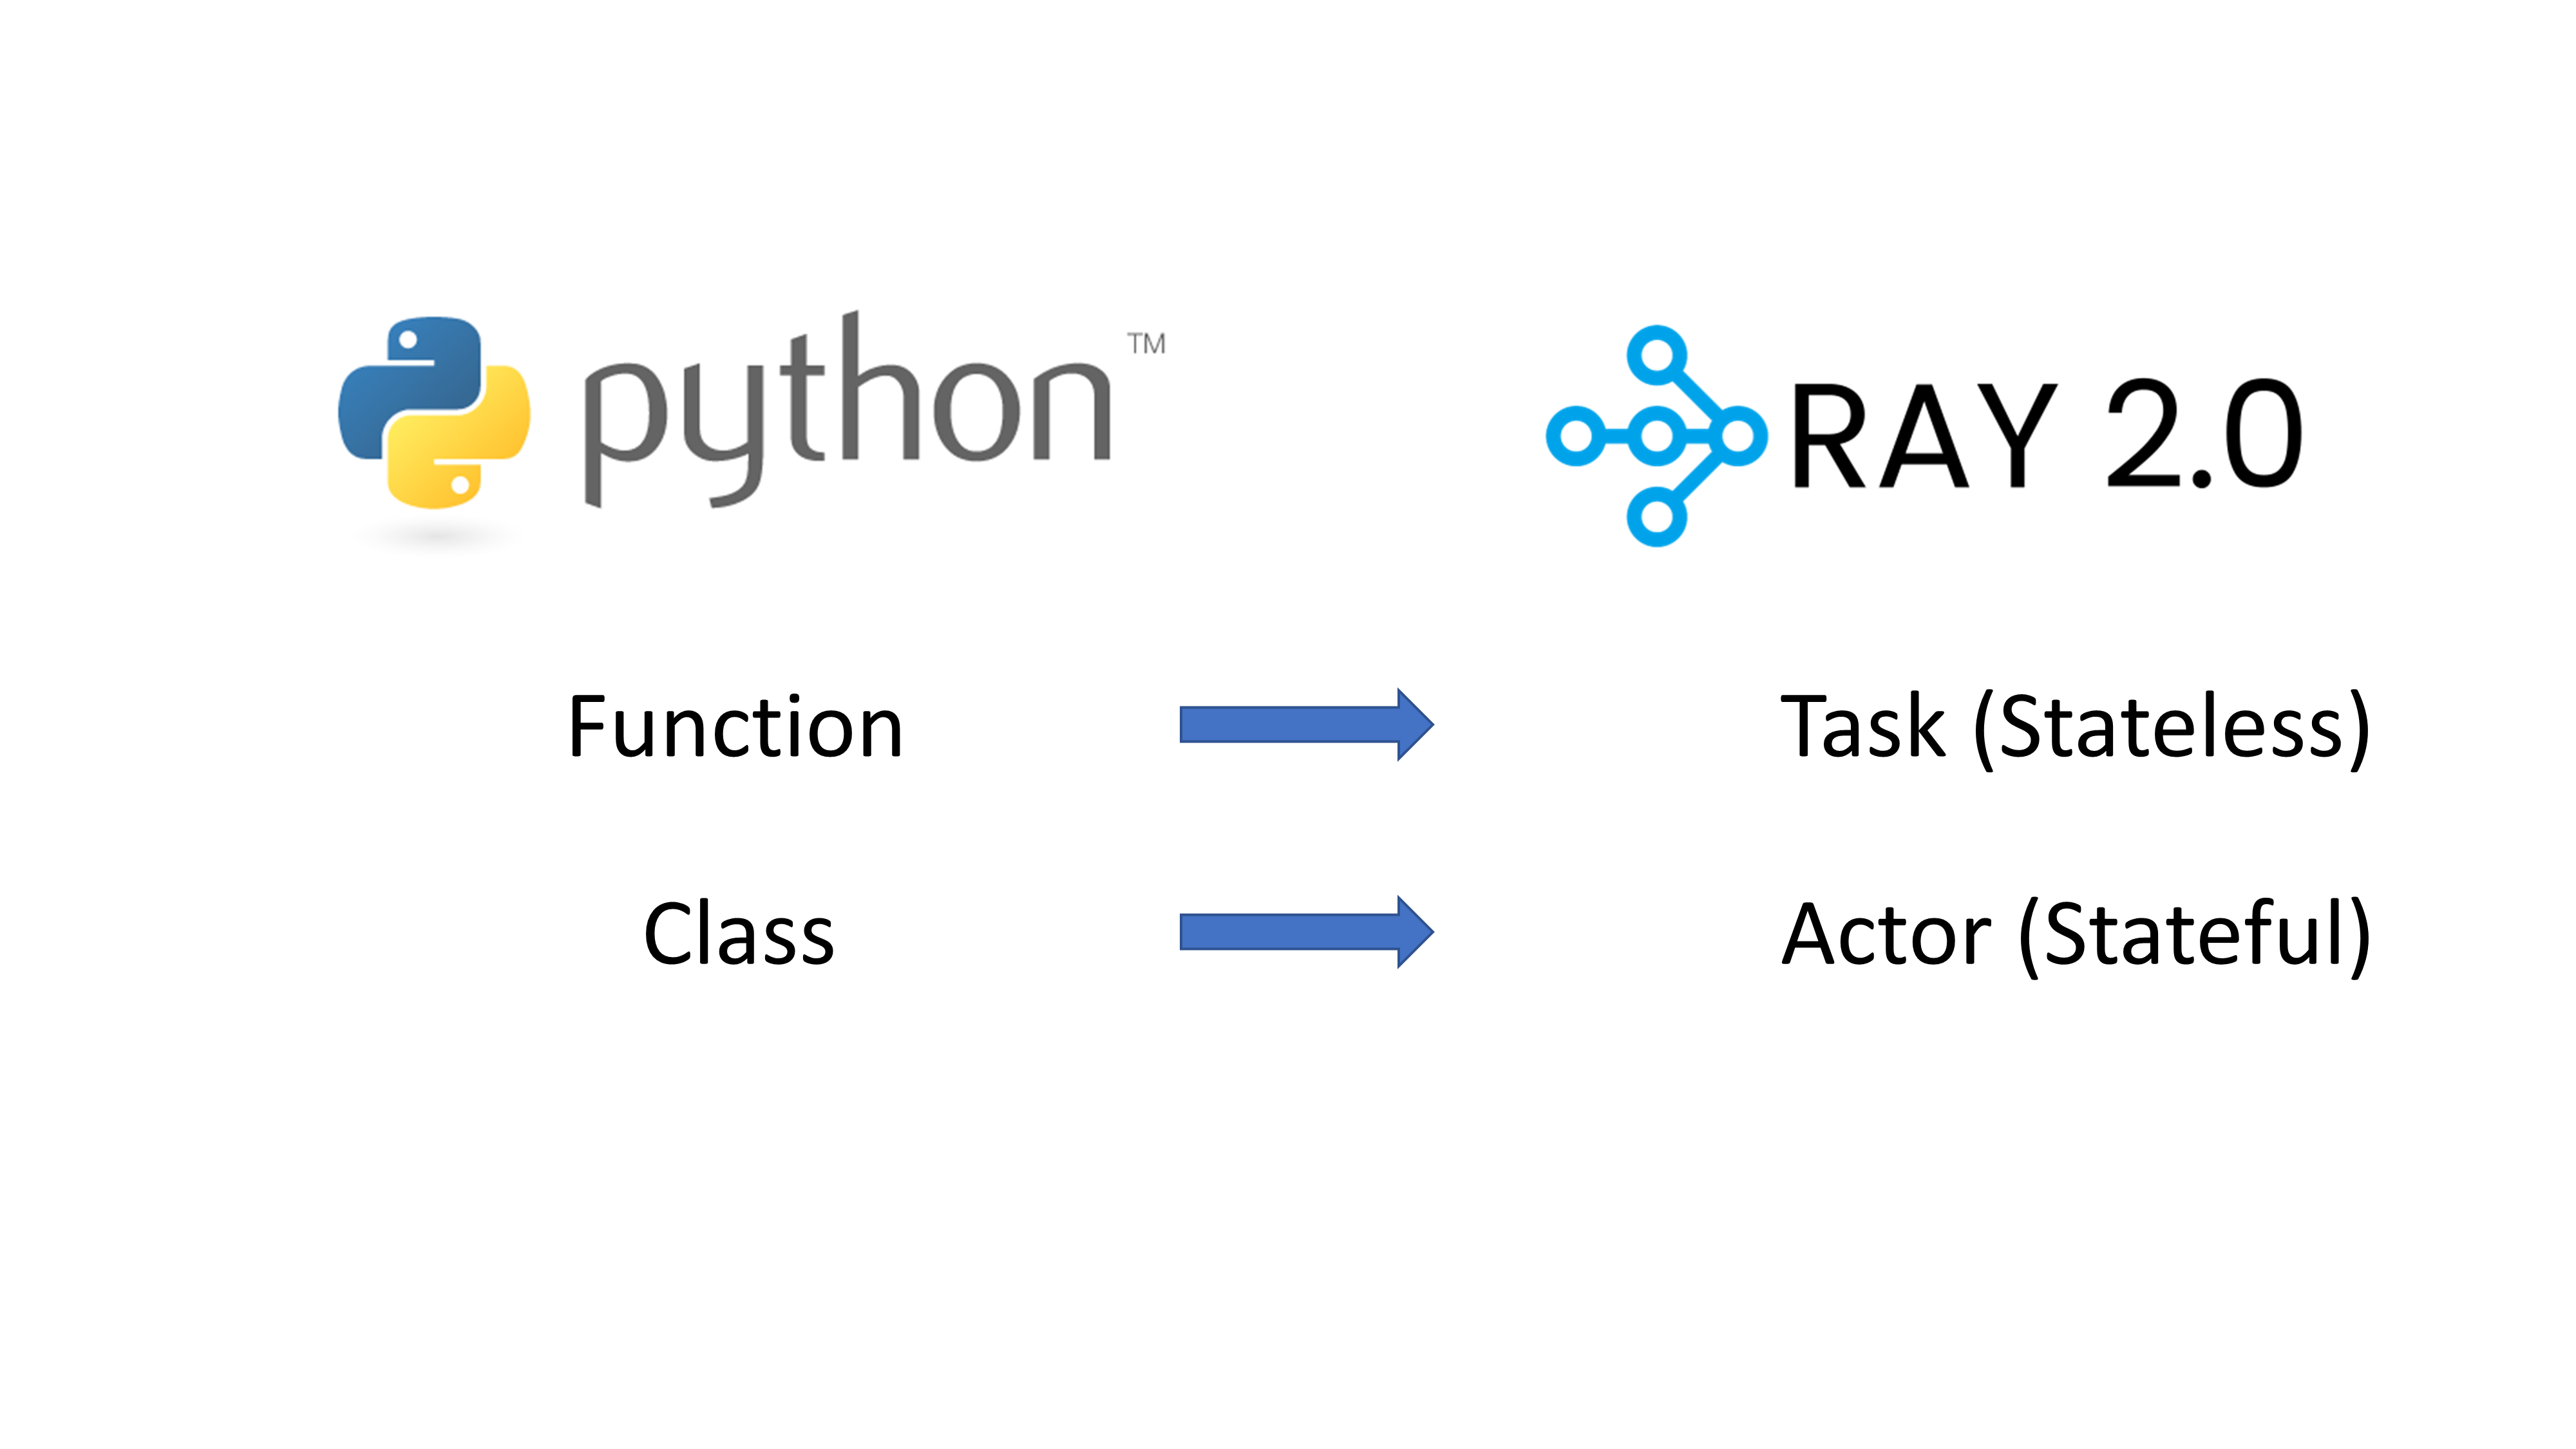

### Ray Task
We can make a parallelizeable function using `ray.remote` (hands-on)
  


In [ ]:
# single-process function that takes some time to return
def blackbox_function(t):
    # assume that sleep function represents the blackbox computation
    time.sleep(t)
    return 1

Assume that we have to call this function multiple times independently.  (hands-on)

In [ ]:
# to measure time for sequential executions
t_s = time.time()
# give five seconds to run the blackbox function for four independent calls
ones = [blackbox_function(5) for _ in range(4)]
t_e = time.time()
# elapsed time for the sequential execution
print(f'Sequential execution takes {t_e - t_s} seconds.')
# check if the functions properly completed
print(f'outputs:', ones)

Sequential execution takes 20.012675523757935 seconds.
outputs: [1, 1, 1, 1]


What if we run this function concurrently?  
Ray Core provides simple primitives to build distributed systems.

In [ ]:
# check how many cpus are in the machine
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

Initialize ray instance.  
By default, it detects the numer of virtual CPU cores and GPUs in the machine.  
Otherwise, you may limit the number of CPUs or GPUs using the optional arguments: `num_cpus` and `num_gpus`

In [ ]:
ray.init(ignore_reinit_error=True)

2022-11-07 14:47:19,862	INFO worker.py:1515 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.7.15
Ray version:,2.0.1
Dashboard:,http://127.0.0.1:8265


Define a parallelizeable function using `ray.remote` decorator. (hands-on)

In [ ]:
# multi-process function that takes some time to return
# ray supports a decorator to make a function parallelizeable
@ray.remote
def blackbox_function_parallel(t):
    # assume that sleep function represents the blackbox computation
    time.sleep(t)
    return 1

Call this function multiple times independently, but in parallel this time. (hands-on)

In [ ]:
# to measure time for sequential executions
t_s = time.time()
# give five seconds to run the blackbox function for four independent calls concurrently
tasks = [blackbox_function_parallel.remote(5) for _ in range(4)]
# make sure to use ray.get function to run the remote function
ones = ray.get(tasks)
# elapsed time for the sequential execution
t_e = time.time()
print(f'Parallel execution takes {t_e - t_s} seconds.')
# check if the functions properly completed
print(f'outputs:', ones)

Parallel execution takes 10.444068670272827 seconds.
outputs: [1, 1, 1, 1]


* Quick points:  
    1. Add `.remote` to invoke the remote function. It returns an object reference to create a task to be executed by a worker process.
    2. Use `ray.get` function to execute the task referenced by the object returned by `.remote` function. Otherwise, it will not _run_ the function. 
    3. At the point we call `ray.get`, it _synchronizes_ the tasks, meaning that the main process waits at line #6 for all the child processes to complete.

The `blackbox_function_parallel` function that we decorated with `ray.remote` function is basically _stateless_, meaning that each function call does not differ across calls in terms of internal _state_ of the function.  
On the other hand, we can make _stateful_ actors by decorating the class with `ray.remote`.  


### Ray Actor (hands-on)

We can define a parallelizeable class using `ray.remote`

In [ ]:
# Counter class has an internal state named counter that records the runnning time
class Counter(object):
    def __init__(self):
        self.counter = 0

    def get_counter(self):
        return self.counter

    def blackbox_function(self, t):
        t_s = time.time()
        # assume that sleep function represents the blackbox computation
        time.sleep(t)
        t_e = time.time()
        self.update_counter(t)

    def update_counter(self, t):
        self.counter += t

Execute the blackbox function multiple times sequentially.



In [ ]:
# to measure time for single process counter
t_s = time.time()
counter = Counter()
# execute blackbox function 16 times sequentially
for _ in range(16):
    counter.blackbox_function(1)
t_e = time.time()
# elapsed time for the single process sequential counter 
print(f'Sequential execution takes {t_e - t_s} seconds.')
# check if the functions properly completed
print(f'Counter state:', counter.get_counter())

Sequential execution takes 16.02152419090271 seconds.
Counter state: 16


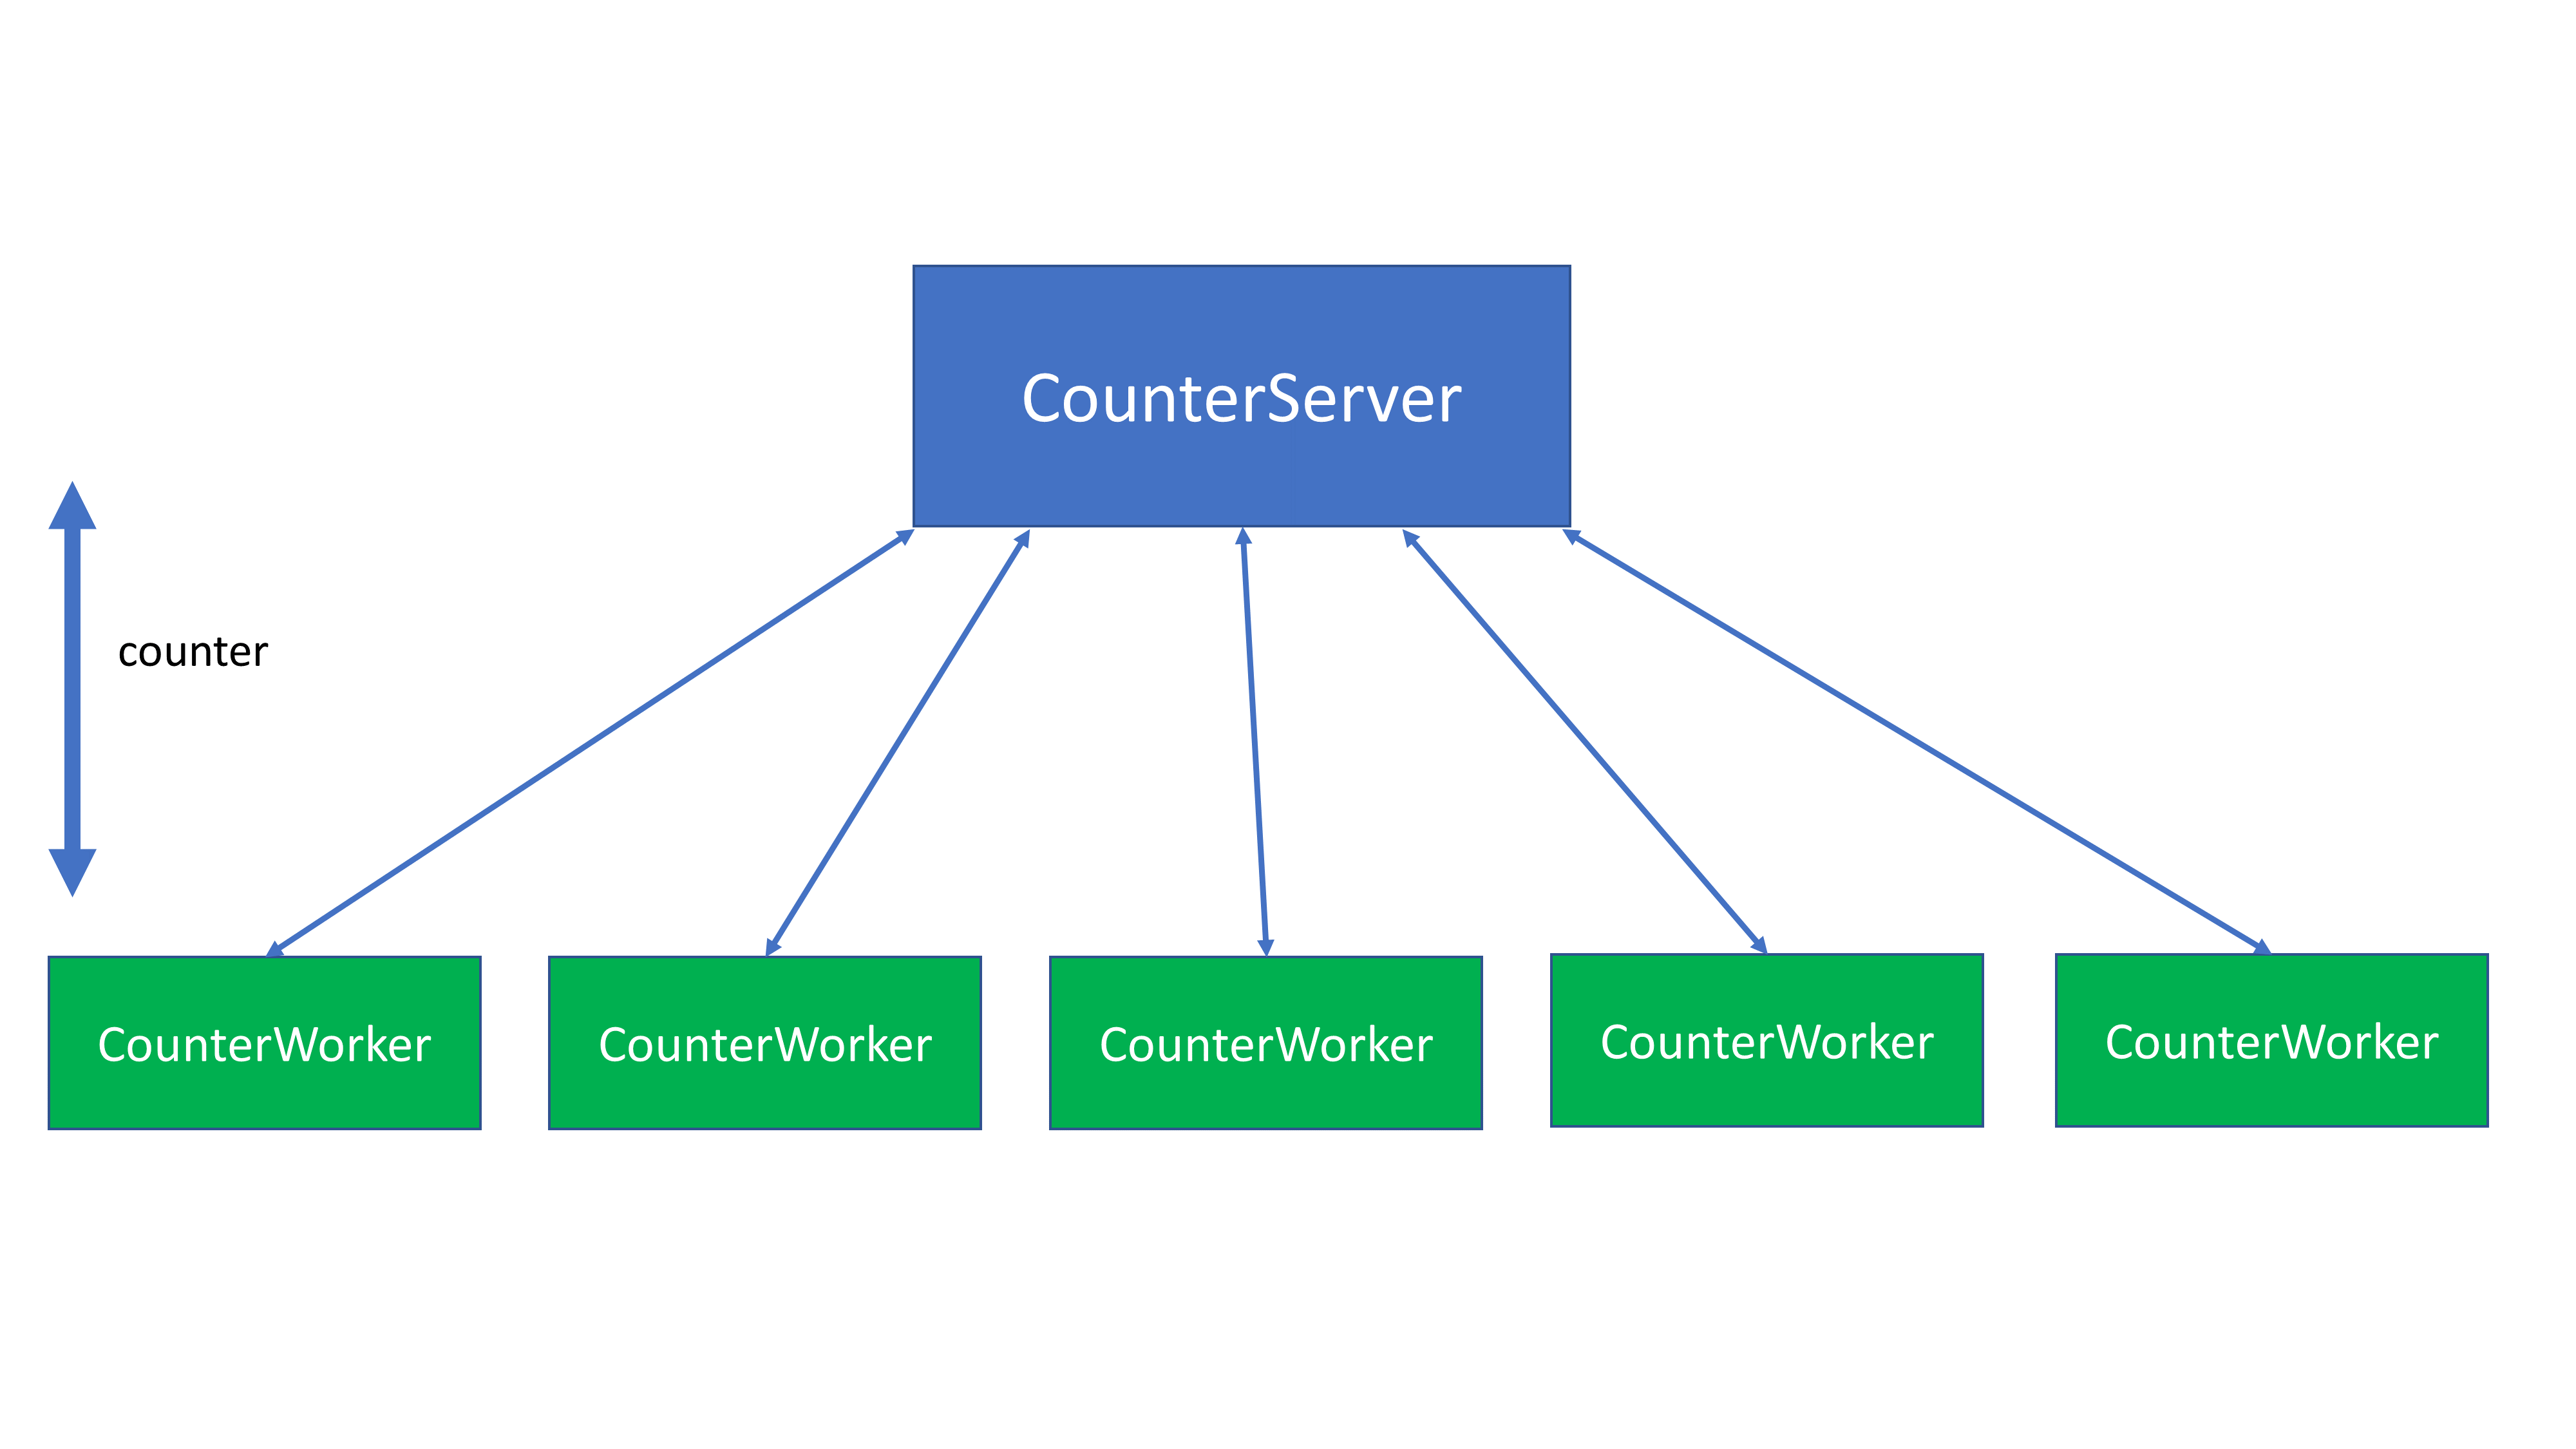

Now we distribute this task to multiple actors.  
First, define the central server class.  

In [ ]:
@ray.remote
class CounterServer(object):
    def __init__(self):
        self.cumulative_counter = 0

    def get_cumulative_counter(self):
        return self.cumulative_counter

    def update_cumulative_counter(self, counters):
        aggregated_counter = sum(counters) if isinstance(counters, list) else counters
        self.cumulative_counter += aggregated_counter
        return self.cumulative_counter

Next, define the worker class.

In [ ]:
# note that we can specify the number of CPU and GPUs for each actor
# also, we can specify the fraction of GPU for each actor, i.e.,num_gpus=0.2
@ray.remote(num_cpus=1, num_gpus=0)
class CounterWorker(object):
    def __init__(self):
        self.local_counter = 0

    def get_local_counter(self):
        return self.local_counter

    def clear_local_counter(self):
        self.local_counter = 0

    def blackbox_function(self, t):
        t_s = time.time()
        time.sleep(t)
        t_e = time.time()
        self.update_local_counter(t)

    def update_local_counter(self, t):
        self.local_counter += t

Execute the blackbox function multiple times concurrently.  
It runs synchronously in this example.  

In [ ]:
t_s = time.time()
# initialize the central server object
counter_server = CounterServer.remote()
# initialize two actors.
counter_workers = [CounterWorker.remote() for _ in range(2)]
local_counters = []
# total 16 runs of blackbox function
iteration = 8
# concurrent execution of blackbox function in multiple workers
for i in range(iteration):
    for cw in counter_workers:
        cw.blackbox_function.remote(1)
        local_counters.append(cw.get_local_counter.remote())
        cw.clear_local_counter.remote()
local_counters = ray.get(local_counters)
print('local counters:', local_counters)
# update the central server's counter by aggregating the local counters
current_cumulative_counter = ray.get(counter_server.update_cumulative_counter.remote(local_counters))
print('current cumulative counters:', current_cumulative_counter)
t_e = time.time()
# elapsed time for the multi process counter 
print(f'Concurrent execution takes {t_e - t_s} seconds.')
# check if the functions properly completed
print(f'Counter state:', current_cumulative_counter)

local counters: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
current cumulative counters: 16
Concurrent execution takes 9.976863145828247 seconds.
Counter state: 16


Can we run it _asynchronously_?

In [ ]:
t_s = time.time()
# initialize the central server object
counter_server = CounterServer.remote()
# initialize two actors.
counter_workers = [CounterWorker.remote() for _ in range(2)]
# in asynchronous version, we define local counters as a dictionary whose key is task id
local_counters = {} 
# total 16 runs of blackbox function
iteration = 8
# initialize local counters: 
# key is object reference of blackbox_function task id, value is worker id
for cw in counter_workers:
    local_counters[cw.blackbox_function.remote(1)] = cw

# concurrent execution of blackbox function in multiple workers
for i in range(iteration):
    for cw in counter_workers:
        ready_local_counters_list, _ = ray.wait(list(local_counters))
        ready_local_counter_id = ready_local_counters_list[0]
        # pop out ready worker
        worker = local_counters.pop(ready_local_counter_id)
        # update cumulative counter in the central server with the ready worker's local counter
        counter_server.update_cumulative_counter.remote(worker.get_local_counter.remote())
        worker.clear_local_counter.remote()
        # re-insert the used worker into the local counter dictionary
        local_counters[worker.blackbox_function.remote(1)] = worker
print('local counters:', local_counters)
current_cumulative_counter = ray.get(counter_server.get_cumulative_counter.remote())
print('current cumulative counters:', current_cumulative_counter)
t_e = time.time()
# elapsed time for the multi process counter 
print(f'Concurrent execution takes {t_e - t_s} seconds.')
# check if the functions properly completed
print(f'Counter state:', current_cumulative_counter)

local counters: {ObjectRef(66e25bed16be8927e7bb9e841fb6e6e253ea73d80100000001000000): Actor(CounterWorker, e7bb9e841fb6e6e253ea73d801000000), ObjectRef(ad8a1e9d6a7a8fc0f49ad500ee71c18a670db9d20100000001000000): Actor(CounterWorker, f49ad500ee71c18a670db9d201000000)}
current cumulative counters: 16
Concurrent execution takes 10.452756404876709 seconds.
Counter state: 16


--------------------------------------
## Difference between Data Parallel and Distributed Data Parallel

In PyTorch,
- Both `DataParllel` and `DistributedDataParallel` allows data parallelism, i.e. splitting mini-batch dataset into different GPUs.
- `DataParllel` is a single-process and multi-thread, while `DistributedDataParallel` is multi-process.
    - Meaning in`DistributedDataParllel`, each process dedicates each GPU. 
    - Due to Python [GIL (Global Interpreter Lock)](https://realpython.com/python-gil/), only one thread gains the control of Python interpreter for each process. 
- `DataParallel` works only in a single machine, while `DistributedDataParallel` works on single and multiple machine. 
- If model size is too large to fit in single GPU, splitting model (model parallelism) is required. `DistributedDataParralel` works with model parallelism, while `DataParallel` cannot.  

## 2. DataParallel

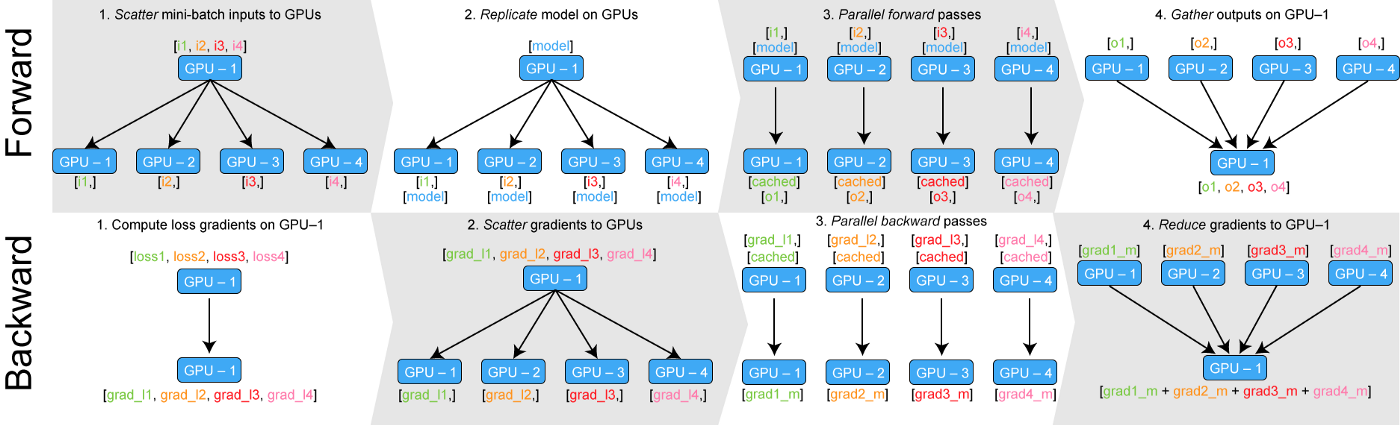
- Images from [here](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255)

`DataParallel` enables single-machine multi-GPU training.

```
torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)

---
module (torch.nn.Module) - your network on torch.nn.Module
device_ids (list of int or torch.device) - which devices you'll work with (default is set to use all devices)
output_device (int or torch.device) - where your output will be collected (default is set to be the first device)
dim - the dimension of tensor to be scattered (default is to be set on 0, which is the batch dimension)
```



In PyTorch, it is relatively easy employing `DataParllel` as shown below

In [ ]:
import torch
import torchvision

model = torchvision.models.resnet50(weights=None).cuda()

# Apply Data Parallel to model defined above.
model = torch.nn.DataParallel(model)

Let's say we will using 4 GPUs (each device ids are 0, 1, 2, 3) and collecting all the losses in second GPU (1):

In [ ]:
# Apply Data Parallel using 4 GPUs and collecting the losses in second GPU
model = torch.nn.DataParallel(model, device_ids=[0,1,2,3], output_device=1)

Let's see the running example here: https://github.com/UNIST-LIM-Lab-course/multi-gpu/blob/main/main_dp.py.

In Summary,

- Using `DataParallel`, the output is gathered to one GPU (`gather`) and compute the gradients.

- After gradients from different GPUs are computed, the backpropagation is done separately, and the separate gradients are reduced into one GPU (`reduce`).

    - `gather` and `reduce` does not seem efficient.


## 3. Distributed Data Parallel

- The main difference between `DataParallel` and `DistributedDataParallel` is whether it is working on single process or **multi process**.

- `DistributedDataParallel` do not `gather` the output and `reduce` the gradients into one GPU; it rather computes the loss and updates the model parameters individually.

- We call this `all_gather` and `all_reduce`.
    - `all_gather` copies tensors from all processes to shared tensor list in all processes.
    - `all_reduce` applies some operation on tensors and the results are stored in all processes.

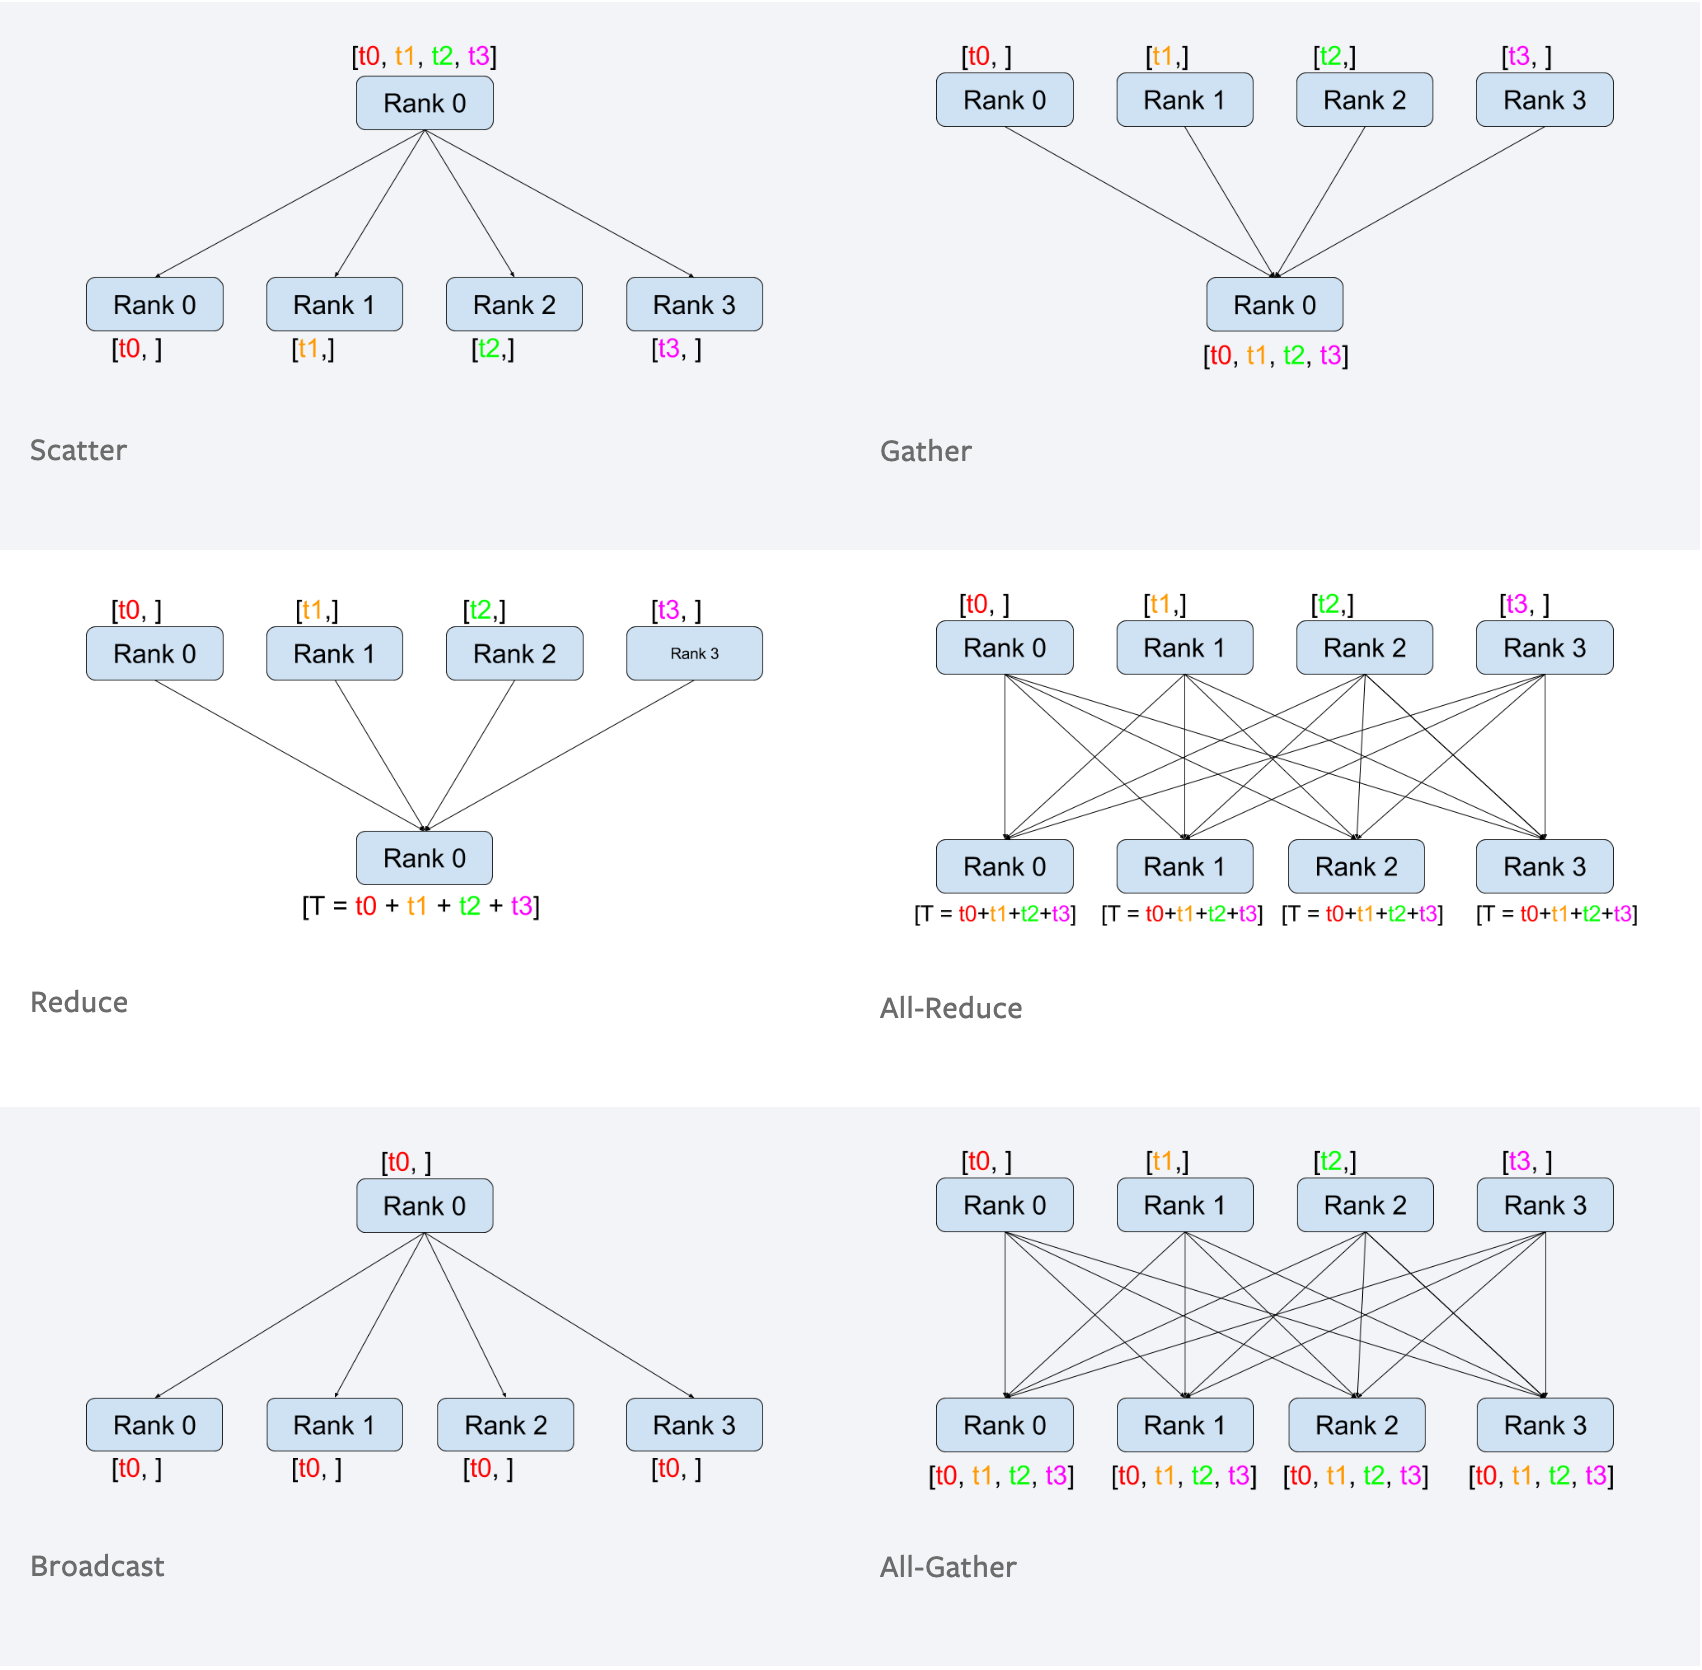
- Images from [here](https://pytorch.org/tutorials/intermediate/dist_tuto.html)

In PyTorch, using `DistributedDataParallel` is complicated than `DataParallel`.
- Initialize process pool.
- Distributing dataset into each GPU.
- Distributing the model parameters into each GPU.

In [ ]:
import torch.distributed as dist
import os

# Initialize Process Groups
dist.init_process_group(backend='nccl')

# Set the rank for each processes
local_rank = int(os.environ["LOCAL_RANK"])

# (Option) Assign GPUs - it is more encouraged to use `CUDA_VISIBLE_DEVICES` environment variable
torch.cuda.set_device(local_rank)

# Get the total number of GPUs to be used - used for distributing data
world_size = torch.distributed.get_world_size() 

In [ ]:
dataset = torchvision.dataset.CIFAR100()

# Split the data with respect to the world_size (total number of GPUs)
# Each GPU will be assign divided portion of dataset -> Q, Then does each GPU will get the same training indices?
# If the dataset is not evenly divisible by the world_size, then you can drop the remainder by setting `drop_last=True`, which is default
# Otherwise, `drop_last=False` will get extra portions of data by generating similar batch_sized data
sampler = dist.DistributedSampler(dataset, num_replicas=world_size, rank=local_rank, drop_last=False)

dataloader = torch.utils.data.DataLoader(dataset, sampler=sampler)

In [ ]:
model = torchvision.models.resnet50(weights=None).cuda()

# Apply Distributed Data Parallel to the model defined above
model = torch.nn.parallel.DistributedDataParallel(model,
                                                  device_ids=[local_rank],
                                                  output_device=local_rank)

Launching DDP model, you need to modify the scipt as follows:
1. For single-machine multi-processing distributed training:

    If your PyTorch version < 1.9, use `torch.distributed.launch`

    ```script
    $ python3 -m torch.distributed.launch --nproc_per_node=NUMBER_OF_GPUS PYTHON_SCRIPT.py --arg1 --arg2
    ```

    If your PyTorch version >= 1.9, use either `torch.distributed.launch` or `torchrun` from TorchElastic.

    ```
    $ torchrun --standalone --nnodes=NUM_NODES --nproc_per_node=NUMBER_OF_GPUS PYTHON_SCRIPT.py --arg1 --arg2
    ```

2. For multi-machine multi-processing distributed training: (let's say 2 machines or nodes)

    If your PyTorch version < 1.9, use `torch.distributed.launch`.
    
    Node 1:

    ```
    $ python3 -m torch.distributed.launch --nproc_per_node=NUMBER_OF_GPUS  
                    --nnodes=NUMBER_OF_MACHINES --node_rank=0 --master_addr=IP_Address  
                    --master_port=PORT --PYTHON_SCRIPT.py --arg1 --arg2
    ```

    Node 2:

    ```
        $ python3 -m torch.distributed.launch --nproc_per_node=NUMBER_OF_GPUS
                    --nnodes=NUMBER_OF_MACHINES --node_rank=1 --master_addr=IP_Address
                    --master_port=PORT --PYTHON_SCRIPT.py --arg1 --arg2
    ```

    If your PyTorch version >= 1.9, use either `torch.distributed.launch` or `torchrun` from TorchElastic.

    Node 1:

    ```
    $ torchrun --rdzv_back=c10d --rdzv_endpoint=HOST:PORT
            --nnodes=NUMBER_OF_MACHINES  --node_rank=0 
            --nproc_per_node=NUMBER_OF_GPUS PYTHON_SCRIPT.py --arg1 --arg2
    ```

    Node 2:

    ```
    $ torchrun --rdzv_back=c10d --rdzv_endpoint=HOST:PORT 
            --nnodes=NUMBER_OF_MACHINES --node_rank=1 
            --nproc_per_node=NUMBER_OF_GPUS PYTHON_SCRIPT.py --arg1 --arg2
    ```


Let's see the example in here: https://github.com/UNIST-LIM-Lab-course/multi-gpu/blob/main/main_ddp.py.